# Vehicle Detection for Autonomous Cars with Image Segmentation
The goal of this project is to train a neural network that can detect vehicles and other object from a video stream from a car. The technique we will be using is image segmentation. Based on the Dr.Yadav's paper, the trained model sometimes will perform better than humans.

In [1]:
# import library
import cv2
import os, sys
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
% matplotlib inline
import glob
import img_util
import training_util
import pandas as pd
from decimal import Decimal

import keras
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D,Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from scipy.ndimage.measurements import label
import time

Using TensorFlow backend.


## Loading the Crowdai data
In the first section, we will load the training data from a folder. The 4.5GB dataset is not part of the repo. Also, let's do some simple preprocessing.

In [4]:
os.chdir("/Volumes/Personal_Drive/Datasets/Vehicle_Detection/")
dir_label = ['object-dataset', 'object-detection-crowdai']

In [5]:
# Make data frame in Pandas
df_files1 = pd.read_csv(dir_label[1]+'/labels.csv', header=0)
df_vehicles1 = df_files1[(df_files1['Label']=='Car') | (df_files1['Label']=='Truck')].reset_index()
df_vehicles1 = df_vehicles1.drop('index', 1)
df_vehicles1['File_Path'] =  dir_label[1] + '/' + df_vehicles1['Frame']
df_vehicles1 = df_vehicles1.drop('Preview URL', 1)
print(dir_label[1])
df_vehicles1.head()

object-detection-crowdai


,xmin,ymin,xmax,ymax,Frame,Label,File_Path
0,785,533,905,644,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
1,89,551,291,680,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
2,268,546,383,650,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
3,455,522,548,615,1479498371963069978.jpg,Truck,object-detection-crowdai/1479498371963069978.jpg
4,548,522,625,605,1479498371963069978.jpg,Truck,object-detection-crowdai/1479498371963069978.jpg


In [6]:
### Get data frame from second source
### Renamed columns to correct xmin, xmax, ymin, ymax values.
### REnamed frames and labels to match crowd-awi source

df_files2 = pd.read_csv('object-dataset/labels.csv', header=None)
df_files2.columns= ['Frame',  'xmin', 'xmax', 'ymin','ymax', 'ind', 'Label']
df_vehicles2 = df_files2[(df_files2['Label'] == 'car') | (df_files2['Label'] == 'truck')].reset_index()
df_files2 = df_files2[(df_files2['Label'] == 'car') | (df_files2['Label'] == 'truck')].reset_index()
df_vehicles2 = df_vehicles2.drop('index', 1)
df_vehicles2 = df_vehicles2.drop('ind', 1)

frames = df_files2["Frame"]
xmin = df_files2["xmin"]
xmax = df_files2["xmax"]
ymin = df_files2["ymin"]
ymax = df_files2["ymax"]
label = df_files2["Label"]

df_vehicles2["Frame"] = xmin.values.astype(np.float32)
df_vehicles2["xmin"] = xmax.values.astype(np.float32)
df_vehicles2["xmax"] = ymin.values.astype(np.float32)
df_vehicles2["ymin"] = ymax.values.astype(np.float32)
df_vehicles2["ymax"] = frames.values
df_vehicles2["Label"] = label.values
df_vehicles2['File_Path'] = dir_label[0] + '/' + frames
df_vehicles2.columns =['xmin','ymin','xmax','ymax','Frame','Label','File_Path']

df_vehicles2.head()

,xmin,ymin,xmax,ymax,Frame,Label,File_Path
0,950.0,574.0,1004.0,620.0,1478019952686311006.jpg,car,object-dataset/1478019952686311006.jpg
1,872.0,586.0,926.0,632.0,1478019953180167674.jpg,car,object-dataset/1478019953180167674.jpg
2,686.0,566.0,728.0,618.0,1478019953689774621.jpg,truck,object-dataset/1478019953689774621.jpg
3,716.0,578.0,764.0,622.0,1478019953689774621.jpg,car,object-dataset/1478019953689774621.jpg
4,826.0,580.0,880.0,626.0,1478019953689774621.jpg,car,object-dataset/1478019953689774621.jpg


In [7]:
# # log the last few entries
# ### Combine data frames
# df_vehicles = pd.concat([df_vehicles1]).reset_index()
# df_vehicles = pd.concat([df_vehicles1, df_vehicles2]).reset_index()
# #df_vehicles = df_vehicles.drop('index', 1)
# #df_vehicles.columns =['File_Path','Frame','Label','xmin','ymin','xmax','ymax']
# df_vehicles.columns =['xmin','ymin','xmax','ymax','Frame','Label','File_Path']
# df_vehicles.head()

# Get data frame from second source, however, we don't have one.
# Then, let's just use the first one.
# df_vehicles2
df_vehicles = pd.concat([df_vehicles1]).reset_index()
df_vehicles = df_vehicles.drop('index', 1)
df_vehicles.columns =['xmin','ymin','xmax','ymax','Frame','Label','File_Path']
print(df_vehicles.shape)
df_vehicles.head()

(66389, 7)


,xmin,ymin,xmax,ymax,Frame,Label,File_Path
0,785,533,905,644,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
1,89,551,291,680,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
2,268,546,383,650,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
3,455,522,548,615,1479498371963069978.jpg,Truck,object-detection-crowdai/1479498371963069978.jpg
4,548,522,625,605,1479498371963069978.jpg,Truck,object-detection-crowdai/1479498371963069978.jpg


In [8]:
df_vehicles.tail()

,xmin,ymin,xmax,ymax,Frame,Label,File_Path
66384,958,559,1045,621,1479506176491553178.jpg,Car,object-detection-crowdai/1479506176491553178.jpg
66385,1038,558,1122,630,1479506176491553178.jpg,Car,object-detection-crowdai/1479506176491553178.jpg
66386,667,558,747,626,1479506176491553178.jpg,Car,object-detection-crowdai/1479506176491553178.jpg
66387,730,568,818,613,1479506176491553178.jpg,Car,object-detection-crowdai/1479506176491553178.jpg
66388,435,551,532,589,1479506176491553178.jpg,Car,object-detection-crowdai/1479506176491553178.jpg


## Testing translation and stretching augmentations
I created a image utility file (img_util.py) based on the u-net project by ViveK Yadav PhD. The file include utility functions for translation, stretching and other augmentations. 

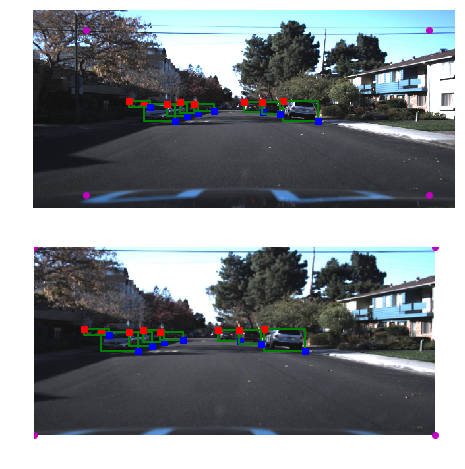

In [7]:
# translation constants
#### Test translation and stretching augmentations

name_str,img,bb_boxes = img_util.get_image_name(df_vehicles, 66388,augmentation=False,trans_range=0,scale_range=0)
img_mask = img_util.get_mask_seg(img,bb_boxes)

tr_x1 = 80
tr_y1 = 30
tr_x2 = 40
tr_y2 = 20


p1 = (tr_x1,tr_y1)
p2 = (img.shape[1]-tr_x2,tr_y1)

p3 = (img.shape[1]-tr_x2,img.shape[0]-tr_y2)
p4 = (tr_x1,img.shape[0]-tr_y2)

pts1 = np.float32([[p1[0],p1[1]],
                   [p2[0],p2[1]],
                   [p3[0],p3[1]],
                   [p4[0],p4[1]]])
pts2 = np.float32([[0,0],
                   [img.shape[1],0],
                   [img.shape[1],img.shape[0]],[0,img.shape[0]]])

M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(img,M,(img.shape[1],img.shape[0]))
dst = np.array(dst,dtype=np.uint8)


plt.figure(figsize=(12,8))
plt.subplot(2, 1, 1)
plt.imshow(img)
plt.plot(p1[0],p1[1],'mo')
plt.plot(p2[0],p2[1],'mo')
plt.plot(p3[0],p3[1],'mo')
plt.plot(p4[0],p4[1],'mo')

for i in range(len(bb_boxes)):
    img_util.plot_bbox(bb_boxes,i,'g')

    bb_box_i = [bb_boxes.iloc[i]['xmin'],bb_boxes.iloc[i]['ymin'],
                bb_boxes.iloc[i]['xmax'],bb_boxes.iloc[i]['ymax']]
    plt.plot(bb_box_i[0],bb_box_i[1],'rs')
    plt.plot(bb_box_i[2],bb_box_i[3],'bs')
    
plt.axis('off')
plt.subplot(2, 1, 2)
plt.imshow(dst)
bb_boxes1 = bb_boxes.copy(deep=True)
bb_boxes1['xmin'] = (bb_boxes['xmin'] - p1[0])/(p2[0]-p1[0])*img.shape[1]
bb_boxes1['xmax'] = (bb_boxes['xmax'] - p1[0])/(p2[0]-p1[0])*img.shape[1]
bb_boxes1['ymin'] = (bb_boxes['ymin'] - p1[1])/(p3[1]-p1[1])*img.shape[0]
bb_boxes1['ymax'] = (bb_boxes['ymax'] - p1[1])/(p3[1]-p1[1])*img.shape[0]
plt.plot(0,0,'mo')
plt.plot(img.shape[1],0,'mo')
plt.plot(img.shape[1],img.shape[0],'mo')
plt.plot(0,img.shape[0],'mo')
img_util.plot_image_bbox(dst,bb_boxes1)

plt.axis('off');

## More testing translation and stretching augmentation
In this section, we will test the helper functions for stretching and translation. Once again, all the image util function can be found in the img_util.py file

(300, 640, 1)


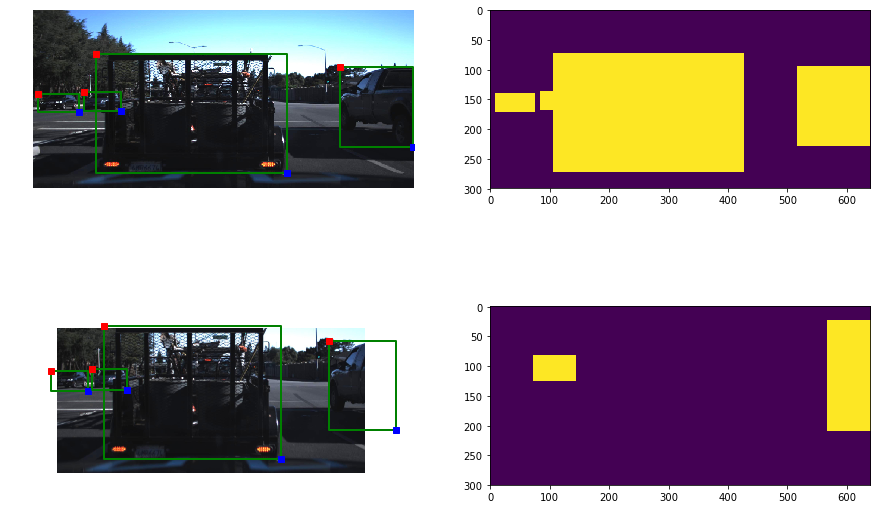

In [8]:
name_str, img, bb_boxes = img_util.get_image_name(df_vehicles,7623, augmentation=False)
img_mask = img_util.get_mask_seg(img, bb_boxes)

print(img_mask.shape)

# plot the image with bounding boxes
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
img_util.plot_image_bbox(img, bb_boxes)

# plot the mask
plt.subplot(2, 2, 2)
plt.imshow(img_mask[:, :, 0])

plt.subplot(2, 2, 3)
dst, bb_boxes1 = img_util.stretch_image(img, bb_boxes, 100)

plt.imshow(dst)

img_util.plot_image_bbox(dst,bb_boxes1)

plt.subplot(2,2,4)
img_mask2 = img_util.get_mask_seg(dst,bb_boxes1)
plt.imshow(img_mask2[:, :, 0]);

### Let's test more translation and segmentations
We will randomly pick another image, put bounding boxes around cars and also show a overlay. 
Let's display the image 100th entry in the dataset.  

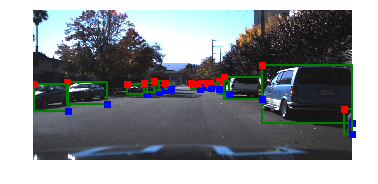

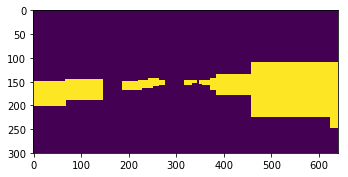

In [9]:
name_str, img, bb_boxes = img_util.get_image_name(df_vehicles, 100, augmentation=False)
img_mask = img_util.get_mask_seg(img, bb_boxes)

# show the bounding boxes of the vehicles
img_util.plot_image_bbox(img, bb_boxes)
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.imshow(img_mask[:, :, 0])

### Training generator, generate augmented images

(66389, 7)


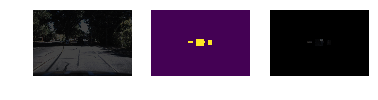

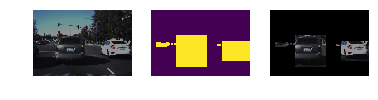

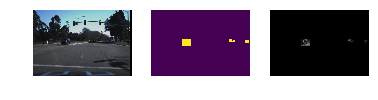

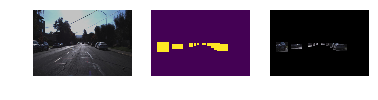

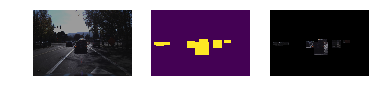

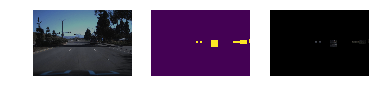

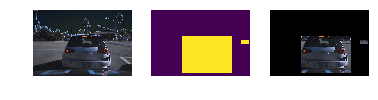

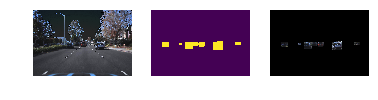

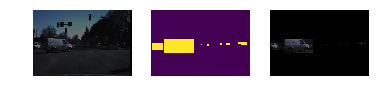

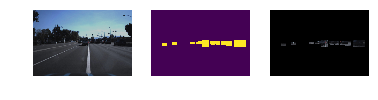

In [10]:
##### Image size,

print(df_vehicles.shape)
training_gen = training_util.generate_train_batch(df_vehicles, 10)
batch_img, batch_mask = next(training_gen)

### Plotting generator output
for i in range(10):
    im = np.array(batch_img[i],dtype=np.uint8)
    im_mask = np.array(batch_mask[i],dtype=np.uint8)
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(im_mask[:,:,0])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(cv2.bitwise_and(im,im,mask=im_mask));
    plt.axis('off')
    plt.show();

# Finally let's build a neural network
It's time to build a convolutional neural network

In [9]:
### IOU or dice coeff calculation

def IOU_calc(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)

    return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def IOU_calc_loss(y_true, y_pred):
    return -IOU_calc(y_true, y_pred)

In [11]:
img_rows = 640
img_cols = 960

inputs = Input((img_rows, img_cols, 3))
inputs_norm = Lambda(lambda x: x/127.5 - 1.)

conv1 = Convolution2D(8, (3, 3), activation="relu", padding="same")(inputs)
conv1 = Convolution2D(8, (3, 3), activation="relu", padding="same")(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Convolution2D(16, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Convolution2D(16, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Convolution2D(32, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Convolution2D(32, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Convolution2D(64, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Convolution2D(64, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Convolution2D(128, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Convolution2D(128, (3, 3), activation='relu', padding='same')(conv5)

up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=3)
conv6 = Convolution2D(64, (3, 3), activation='relu', padding='same')(up6)
conv6 = Convolution2D(64, (3, 3), activation='relu', padding='same')(conv6)

up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=3)
conv7 = Convolution2D(32, (3, 3), activation='relu', padding='same')(up7)
conv7 = Convolution2D(32, (3, 3), activation='relu', padding='same')(conv7)

up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=3)
conv8 = Convolution2D(16, (3, 3), activation='relu', padding='same')(up8)
conv8 = Convolution2D(16, (3, 3), activation='relu', padding='same')(conv8)

up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=3)
conv9 = Convolution2D(8, (3, 3), activation='relu', padding='same')(up9)
conv9 = Convolution2D(8, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Convolution2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(input=inputs, output=conv10)

TypeError: __init__() missing 1 required positional argument: 'nb_col'

In [13]:
smooth = 1.
model.compile(optimizer=Adam(lr=1e-4), loss="sparse_categorical_crossentropy")

In [14]:
training_gen = training_util.generate_train_batch(df_vehicles,1)

history = model.fit_generator(training_gen, steps_per_epoch=1200, epochs=2, verbose=1, callbacks=None, validation_data=None)

Epoch 1/2


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [ ]:
from keras.models import load_model
model.save('train-1.h5')

In [ ]:
print(history.history)

In [ ]:
### IOU or dice coeff calculation

def IOU_calc(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)

    return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def IOU_calc_loss(y_true, y_pred):
    return -IOU_calc(y_true, y_pred)

model = load_model("/Users/YongyangNie/Desktop/train-1.h5")

In [ ]:
model.load_weights("train-1.h5")
model.compile(optimizer=Adam(lr=1e-4), loss=IOU_calc_loss, metrics=[IOU_calc])